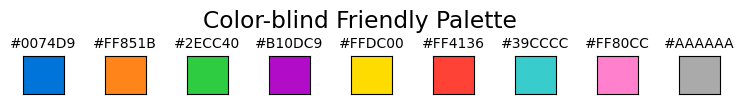

In [1]:
import re
import sys
import torch
import pickle
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.rcParams['font.family'] = 'arial' 
plt.rcParams['font.weight'] = 'normal' 
plt.rcParams['font.size'] = 14

from tqdm.notebook import tqdm
from dataclasses import dataclass
from pathlib import Path
from scipy.interpolate import interp1d
from collections import defaultdict
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.axisartist.axislines import AxesZero

# Add the parent folder, i.e. project root, to path
sys.path.append(str(Path.cwd().parent))

from src.data import BatteryData
from src.builders import MODELS
from src.utils import import_config

pd.options.display.precision = 1
palette = [
    '#0074D9',  # blue
    '#FF851B',  # orange
    '#2ECC40',  # green
    '#B10DC9',  # purple
    '#FFDC00',  # yellow
    '#FF4136',  # red
    '#39CCCC',  # teal
    '#FF80CC',  # pink
    '#AAAAAA',  # gray
]
# Show palette
fig, axes = plt.subplots(1, len(palette), figsize=(len(palette), 0.5))
for color, ax in zip(palette, axes):
    ax.set_facecolor(color)
    ax.set_title(color, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle('Color-blind Friendly Palette', y=1.8)
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

In [2]:
@dataclass
class ColorSeries:
    main: str
    darker: list[str] = None
    lighter: list[str] = None

    def __post_init__(self):
        self.darker = self.darker or []
        self.lighter = self.lighter or []

    def plot(self, ax):
        colors = self.darker[::-1] + [self.main] + self.lighter
        for i, color in enumerate(colors):
            ax.add_patch(plt.Rectangle((i*50, 0), 50, 50, facecolor=color)) 
            ax.text(i*50 + 25, 25, color, ha='center', va='center')
        ax.set_xlim(0, len(colors)*50)
        ax.set_ylim(0, 50)
        ax.axis('off')


palette = [
    # Blues
    ColorSeries('#0074D6', ['#0C4CED', '#0B10E3'], ['#0CC3ED', '#0BE3D1']),
    # Orange
    ColorSeries('#FF851B', ['#FFB80F', '#FF390F'], ['#E8920E', '#FFB80F']),
    # Green
]

In [3]:
path = Path('../data/processed/').glob('*/*')
all_batteries = [BatteryData.load(p) for p in tqdm(list(path))]

  0%|          | 0/403 [00:00<?, ?it/s]

In [5]:
import torch
import pickle


with torch.device('cpu'):
    with open('../workspaces/predictions_20230719064753.pkl', 'rb') as f:
        mix20_pred = pickle.load(f)
    
    with open('../workspaces/predictions_20230817093054_0.pkl', 'rb') as f:
        mix100_pred = pickle.load(f)

In [6]:
from src.feature import BatLiNetFeatureExtractor

mix20_fe = BatLiNetFeatureExtractor(
    smooth_features=False,
    max_cycle_index=19,
    cycle_to_drop=10
)
mix100_fe = BatLiNetFeatureExtractor(smooth_features=False)

In [20]:
all_mix100_feats = torch.stack([
    mix100_fe.process_cell(cell) for cell in tqdm(all_batteries)
])
all_mix20_feats = torch.stack([
    mix20_fe.process_cell(cell) for cell in tqdm(all_batteries)
])

  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/403 [00:00<?, ?it/s]

In [1]:
cache_mix100_labels = mix100_pred['data'].train_data.feature
cache_mix20_labels = mix20_pred['data'].test_data.feature

NameError: name 'mix100_pred' is not defined

In [32]:
matched_cells = []
for cache_feat in tqdm(cache_mix100_labels):
    N = len(all_mix100_feats)
    match = (all_mix100_feats.view(N, -1) - cache_feat.view(-1)[None]).abs().mean(-1).argmin()
    matched_cells.append(all_batteries[match])

  0%|          | 0/137 [00:00<?, ?it/s]

In [33]:
for cell in matched_cells:
    print(f'    "{cell.cell_id}",')

    "HUST_1-1",
    "MATR_b3c42",
    "RWTH_011",
    "RWTH_032",
    "MATR_b2c27",
    "MATR_b1c4",
    "MATR_b4c15",
    "RWTH_040",
    "MATR_b1c16",
    "HUST_1-8",
    "RWTH_015",
    "MATR_b3c34",
    "MATR_b4c38",
    "UL-PUR_N10-NA7_18650_NCA_23C_0-100_0.5-0.5C_g",
    "MATR_b3c25",
    "CALCE_CS2_35",
    "UL-PUR_N20-EX2_18650_NCA_23C_0-100_0.5-0.5C_b",
    "HUST_5-1",
    "MATR_b3c26",
    "MATR_b1c26",
    "HUST_4-4",
    "MATR_b4c4",
    "HUST_8-4",
    "RWTH_030",
    "MATR_b3c14",
    "HNEI_18650_NMC_LCO_25C_0-100_0.5-1.5C_e",
    "RWTH_003",
    "MATR_b2c26",
    "MATR_b1c45",
    "MATR_b1c40",
    "MATR_b4c19",
    "HUST_3-6",
    "MATR_b3c24",
    "MATR_b2c12",
    "MATR_b3c17",
    "HUST_5-2",
    "MATR_b1c32",
    "MATR_b2c30",
    "MATR_b2c11",
    "MATR_b1c15",
    "HUST_7-5",
    "HUST_2-6",
    "MATR_b3c35",
    "RWTH_036",
    "HUST_10-8",
    "MATR_b4c41",
    "UL-PUR_N10-OV8_18650_NCA_23C_0-100_0.5-0.5C_h",
    "MATR_b4c22",
    "MATR_b1c42",
    "MATR_b2c43",

In [17]:
test_ids = [
    "HUST_1-1",
    "MATR_b3c7",
    "RWTH_011",
    "RWTH_032",
    "MATR_b2c27",
    "MATR_b1c3",
    "MATR_b4c14",
    "RWTH_040",
    "MATR_b1c16",
    "HUST_1-8",
    "RWTH_015",
    "MATR_b3c1",
    "MATR_b4c38",
    "UL-PUR_N10-NA7_18650_NCA_23C_0-100_0.5-0.5C_g",
    "MATR_b3c9",
    "CALCE_CS2_35",
    "UL-PUR_N20-NA6_18650_NCA_23C_0-100_0.5-0.5C_f",
    "HUST_5-1",
    "MATR_b3c4",
    "MATR_b1c26",
    "HUST_4-4",
    "MATR_b4c4",
    "HUST_8-4",
    "RWTH_030",
    "MATR_b3c12",
    "HNEI_18650_NMC_LCO_25C_0-100_0.5-1.5C_e",
    "RWTH_003",
    "MATR_b2c26",
    "MATR_b1c44",
    "MATR_b1c40",
    "MATR_b4c19",
    "HUST_3-6",
    "MATR_b3c24",
    "MATR_b2c12",
    "MATR_b3c17",
    "HUST_5-2",
    "MATR_b1c32",
    "MATR_b2c30",
    "MATR_b2c11",
    "MATR_b1c14",
    "HUST_7-5",
    "HUST_2-6",
    "MATR_b3c18",
    "RWTH_036",
    "HUST_10-8",
    "MATR_b4c41",
    "UL-PUR_N10-OV8_18650_NCA_23C_0-100_0.5-0.5C_h",
    "MATR_b4c22",
    "MATR_b1c42",
    "MATR_b2c43",
    "MATR_b1c19",
    "HUST_1-4",
    "RWTH_048",
    "HNEI_18650_NMC_LCO_25C_0-100_0.5-1.5C_a",
    "UL-PUR_N15-OV3_18650_NCA_23C_0-100_0.5-0.5C_c",
    "RWTH_045",
    "RWTH_028",
    "MATR_b2c23",
    "HUST_3-4",
    "RWTH_034",
    "MATR_b2c34",
    "MATR_b3c16",
    "MATR_b2c33",
    "MATR_b1c34",
    "MATR_b3c15",
    "MATR_b3c33",
    "HUST_8-7",
    "HUST_10-2",
    "MATR_b4c33",
    "MATR_b1c31",
    "HUST_4-2",
    "HUST_8-6",
    "UL-PUR_N20-EX2_18650_NCA_23C_0-100_0.5-0.5C_b",
    "MATR_b1c7",
    "MATR_b3c11",
    "RWTH_012",
    "MATR_b3c10",
    "MATR_b4c16",
    "MATR_b3c41",
    "RWTH_027",
    "RWTH_005",
    "MATR_b4c8",
    "HUST_6-2",
    "HNEI_18650_NMC_LCO_25C_0-100_0.5-1.5C_l",
    "MATR_b3c14",
    "MATR_b2c1",
    "HUST_4-6",
    "MATR_b3c21",
    "RWTH_039",
    "MATR_b4c26",
    "MATR_b3c2",
    "MATR_b4c24",
    "MATR_b3c22",
    "CALCE_CX2_34",
    "MATR_b1c5",
    "RWTH_019",
    "CALCE_CX2_36",
    "HUST_6-6",
    "RWTH_037",
    "MATR_b4c1",
    "HUST_10-1",
    "MATR_b4c29",
    "HUST_9-4",
    "HUST_8-1",
    "MATR_b4c7",
    "MATR_b3c32",
    "MATR_b4c0",
    "MATR_b2c2",
    "RWTH_041",
    "HUST_10-4",
    "MATR_b2c13",
    "MATR_b4c42",
    "RWTH_044",
    "RWTH_035",
    "MATR_b3c0",
    "HNEI_18650_NMC_LCO_25C_0-100_0.5-1.5C_t",
    "HUST_4-1",
    "HUST_10-7",
    "MATR_b3c13",
    "HUST_8-8",
    "RWTH_023",
    "HUST_7-3",
    "MATR_b1c18",
    "HNEI_18650_NMC_LCO_25C_0-100_0.5-1.5C_s",
    "MATR_b4c20",
    "MATR_b1c8",
    "HUST_9-7",
    "MATR_b2c25",
    "MATR_b2c36",
    "MATR_b3c40",
    "MATR_b2c19",
    "MATR_b2c47",
    "MATR_b4c34",
    "MATR_b4c2",
    "RWTH_002",
    "MATR_b3c3",
    "MATR_b4c9",
]

In [19]:
test_ids[122], matched_cells[122].cell_id

('MATR_b1c18', 'MATR_b1c18')

In [55]:
matched = [False] * len(all_batteries)
matched_cells = []
for cache_feat in tqdm(cache_mix20_labels):
    found_match = False
    for index, (cell, feat) in enumerate(
        zip(all_batteries, all_mix20_feats)
    ):
        if not matched[index] and (feat - cache_feat).abs().mean() < 1e-2:
            matched[index] = True
            found_match = True
            matched_cells.append(cell)
            break
    if not found_match:
        raise

  0%|          | 0/147 [00:00<?, ?it/s]

In [56]:
for cell in matched_cells:
    print(f'    "{cell.cell_id}",')

    "RWTH_011",
    "HUST_9-1",
    "MATR_b2c31",
    "CALCE_CS2_36",
    "MATR_b3c24",
    "MATR_b3c45",
    "RWTH_032",
    "HUST_3-8",
    "MATR_b4c36",
    "RWTH_049",
    "HUST_8-3",
    "HUST_10-8",
    "MATR_b4c23",
    "SNL_18650_NCA_25C_20-80_0.5-0.5C_d",
    "CALCE_CX2_38",
    "RWTH_046",
    "HUST_6-4",
    "MATR_b1c11",
    "HUST_10-5",
    "UL-PUR_N20-NA6_18650_NCA_23C_0-100_0.5-0.5C_f",
    "MATR_b4c38",
    "HUST_7-6",
    "RWTH_013",
    "HUST_7-3",
    "RWTH_008",
    "MATR_b4c5",
    "HUST_2-3",
    "HUST_4-5",
    "MATR_b1c0",
    "HUST_6-3",
    "SNL_18650_NCA_25C_0-100_0.5-0.5C_a",
    "MATR_b1c12",
    "MATR_b1c39",
    "MATR_b2c26",
    "CALCE_CX2_16",
    "HUST_1-7",
    "HUST_9-6",
    "MATR_b3c2",
    "MATR_b1c3",
    "RWTH_025",
    "HUST_1-3",
    "RWTH_031",
    "MATR_b4c44",
    "HUST_2-6",
    "MATR_b2c24",
    "MATR_b2c32",
    "MATR_b4c27",
    "SNL_18650_NCA_25C_20-80_0.5-0.5C_a",
    "MATR_b3c7",
    "MATR_b2c33",
    "MATR_b3c1",
    "MATR_b3c0",
  

In [18]:
# TODO: select a cell from training files with similar label to substitute the MATR_b1c18

In [34]:
train_cells = [cell for cell in all_batteries if cell not in matched_cells]

In [35]:
len(train_cells)

266

In [36]:
len(matched_cells)

137